In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import umap
import sys

sys.path.insert(0, '/home/utig5/johna/bhai/ml_models')
from vae_lithology_gra_v2_5_model import VAE, DistributionAwareScaler

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Load Data and Model

In [2]:
df = pd.read_csv('/home/utig5/johna/bhai/vae_training_data_v2_20cm.csv')

feature_cols = ['Bulk density (GRA)', 'Magnetic susceptibility (instr. units)',
                'NGR total counts (cps)', 'R', 'G', 'B']

unique_boreholes = df['Borehole_ID'].unique()
train_boreholes, test_boreholes = train_test_split(
    unique_boreholes, train_size=0.85, random_state=42
)

test_mask = df['Borehole_ID'].isin(test_boreholes)
df_test = df[test_mask].copy()

X_test = df_test[feature_cols].values
y_test = df_test['Principal'].values

print(f"Test set: {len(df_test):,} samples, {len(np.unique(y_test))} unique lithologies")

Test set: 30,593 samples, 85 unique lithologies


In [3]:
checkpoint = torch.load('ml_models/checkpoints/vae_gra_v2_6_6_latent10.pth', weights_only=False)

model = VAE(input_dim=6, latent_dim=10, hidden_dims=[32, 16])
model.load_state_dict(checkpoint['model_state_dict'])
scaler = checkpoint['scaler']

X_test_scaled = scaler.transform(X_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

with torch.no_grad():
    X_tensor = torch.FloatTensor(X_test_scaled).to(device)
    mu, logvar = model.encode(X_tensor)
    latent = mu.cpu().numpy()

print(f"Latent shape: {latent.shape}")
print(f"Device: {device}")

Latent shape: (30593, 10)
Device: cuda


## Latent Space Statistics

In [4]:
latent_stds = latent.std(axis=0)
collapsed_dims = (latent_stds < 0.1).sum()
effective_dim = (latent_stds >= 0.1).sum()

stats_data = []
for i in range(latent.shape[1]):
    dim_data = latent[:, i]
    stats_data.append({
        'Dimension': i+1,
        'Mean': dim_data.mean(),
        'Std': dim_data.std(),
        'Min': dim_data.min(),
        'Max': dim_data.max(),
        'Range': dim_data.max() - dim_data.min(),
        'Skewness': stats.skew(dim_data),
        'Kurtosis': stats.kurtosis(dim_data)
    })

df_stats = pd.DataFrame(stats_data)
print(df_stats.to_string(index=False))
print(f"\nCollapsed dimensions (std<0.1): {collapsed_dims}/10")
print(f"Effective dimensionality: {effective_dim}")

 Dimension      Mean      Std       Min      Max    Range  Skewness  Kurtosis
         1  0.003188 0.016453 -0.063204 0.069624 0.132828  1.273843  3.005448
         2  0.001722 0.008551 -0.044909 0.037120 0.082029  0.537337  1.981400
         3 -0.001749 0.020413 -0.073903 0.066800 0.140703 -1.707842  2.838876
         4 -0.232296 1.092401 -3.835813 2.964074 6.799888 -1.431977  1.492065
         5  0.003322 0.018381 -0.052608 0.073938 0.126546  1.612932  3.386907
         6 -0.002847 0.013163 -0.048730 0.053444 0.102173  0.049227  0.213409
         7 -0.073616 0.848884 -3.628392 3.243313 6.871706 -0.191191 -0.346619
         8 -0.114541 0.857555 -4.167910 2.659007 6.826918  0.099226  1.342793
         9 -0.159533 0.942725 -4.415529 4.566521 8.982050 -0.298090  1.419068
        10 -0.003302 0.014937 -0.062686 0.029141 0.091827 -2.260749  4.888453

Collapsed dimensions (std<0.1): 6/10
Effective dimensionality: 4


## Q-Q Plots

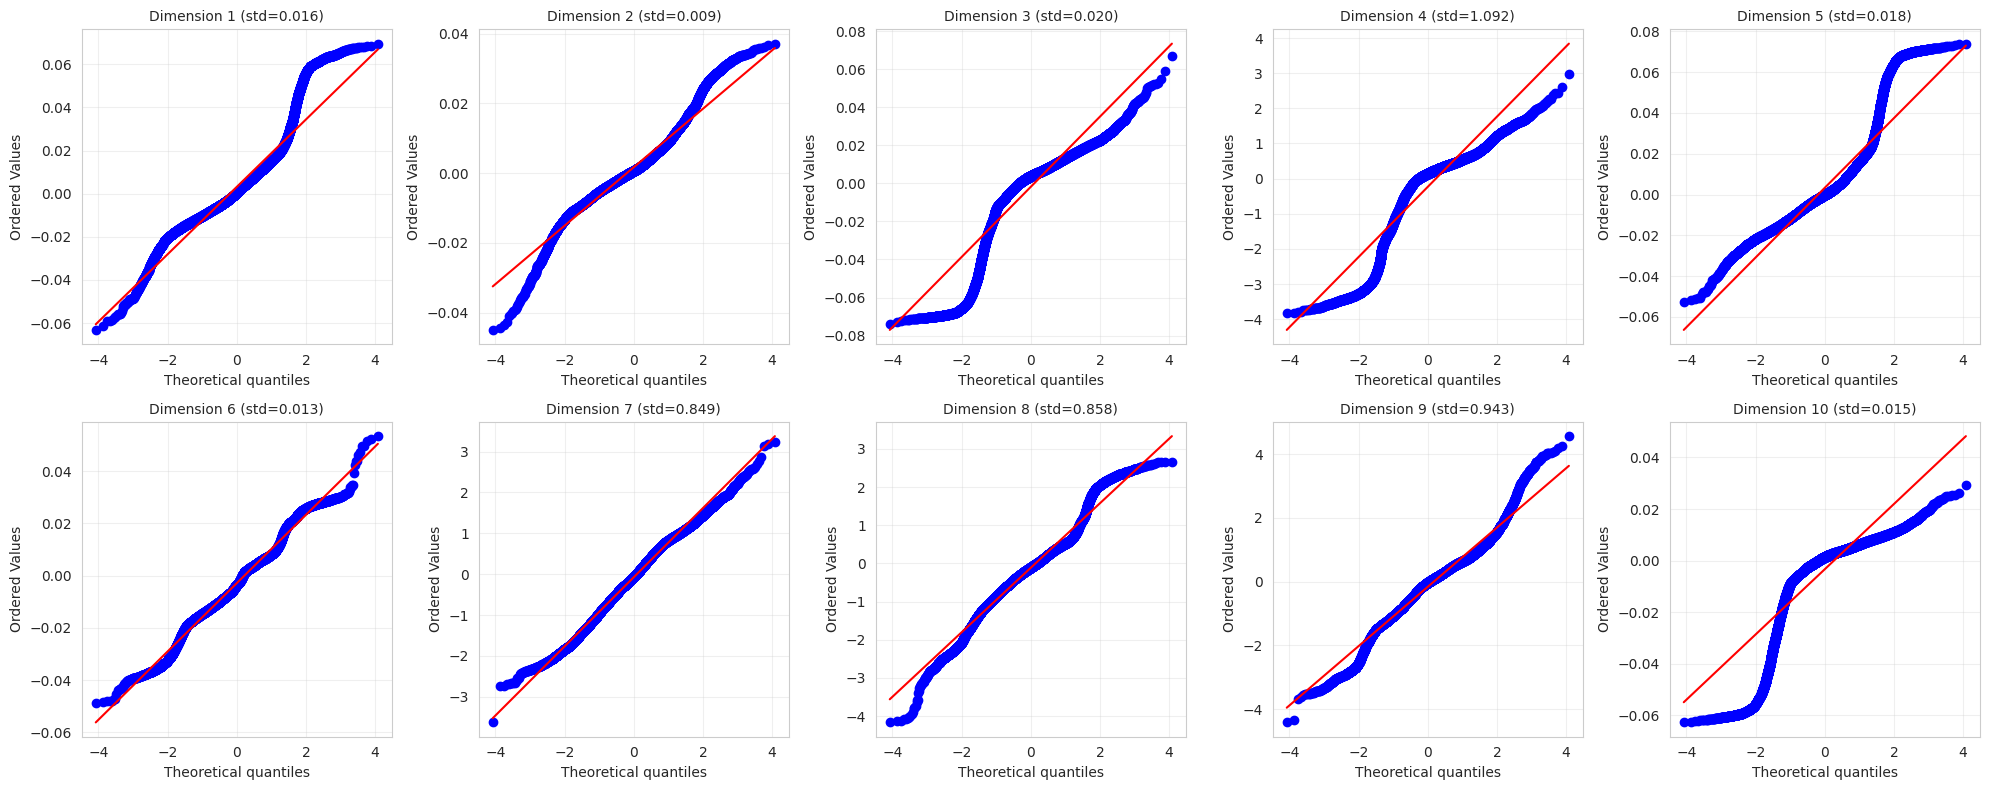

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    stats.probplot(latent[:, i], dist="norm", plot=axes[i])
    axes[i].set_title(f'Dimension {i+1} (std={latent_stds[i]:.3f})', fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Normality Tests

In [6]:
normality_results = []

for i in range(latent.shape[1]):
    dim_data = latent[:, i]
    
    shapiro_stat, shapiro_p = stats.shapiro(dim_data[:5000] if len(dim_data) > 5000 else dim_data)
    ks_stat, ks_p = stats.kstest(dim_data, 'norm', args=(dim_data.mean(), dim_data.std()))
    
    normality_results.append({
        'Dimension': i+1,
        'Mean': dim_data.mean(),
        'Std': dim_data.std(),
        'Skewness': stats.skew(dim_data),
        'Kurtosis': stats.kurtosis(dim_data),
        'Shapiro_p': shapiro_p,
        'KS_p': ks_p,
        'Is_Gaussian_05': (shapiro_p > 0.05) and (ks_p > 0.05)
    })

df_normality = pd.DataFrame(normality_results)
print(df_normality.to_string(index=False))
print(f"\nGaussian dimensions: {df_normality['Is_Gaussian_05'].sum()}/10")

 Dimension      Mean      Std  Skewness  Kurtosis    Shapiro_p          KS_p  Is_Gaussian_05
         1  0.003188 0.016453  1.273843  3.005448 2.788377e-31 1.622867e-196           False
         2  0.001722 0.008551  0.537337  1.981400 5.425162e-43 9.374935e-155           False
         3 -0.001749 0.020413 -1.707842  2.838876 1.805622e-20  0.000000e+00           False
         4 -0.232296 1.092401 -1.431977  1.492065 9.394118e-28  0.000000e+00           False
         5  0.003322 0.018381  1.612932  3.386907 1.578031e-30  0.000000e+00           False
         6 -0.002847 0.013163  0.049227  0.213409 1.236041e-36  2.624895e-52           False
         7 -0.073616 0.848884 -0.191191 -0.346619 2.328215e-42  2.316546e-30           False
         8 -0.114541 0.857555  0.099226  1.342793 3.717121e-43 2.590415e-151           False
         9 -0.159533 0.942725 -0.298090  1.419068 1.337542e-27 8.537492e-116           False
        10 -0.003302 0.014937 -2.260749  4.888453 1.128523e-35  0.0000

## Distribution Histograms

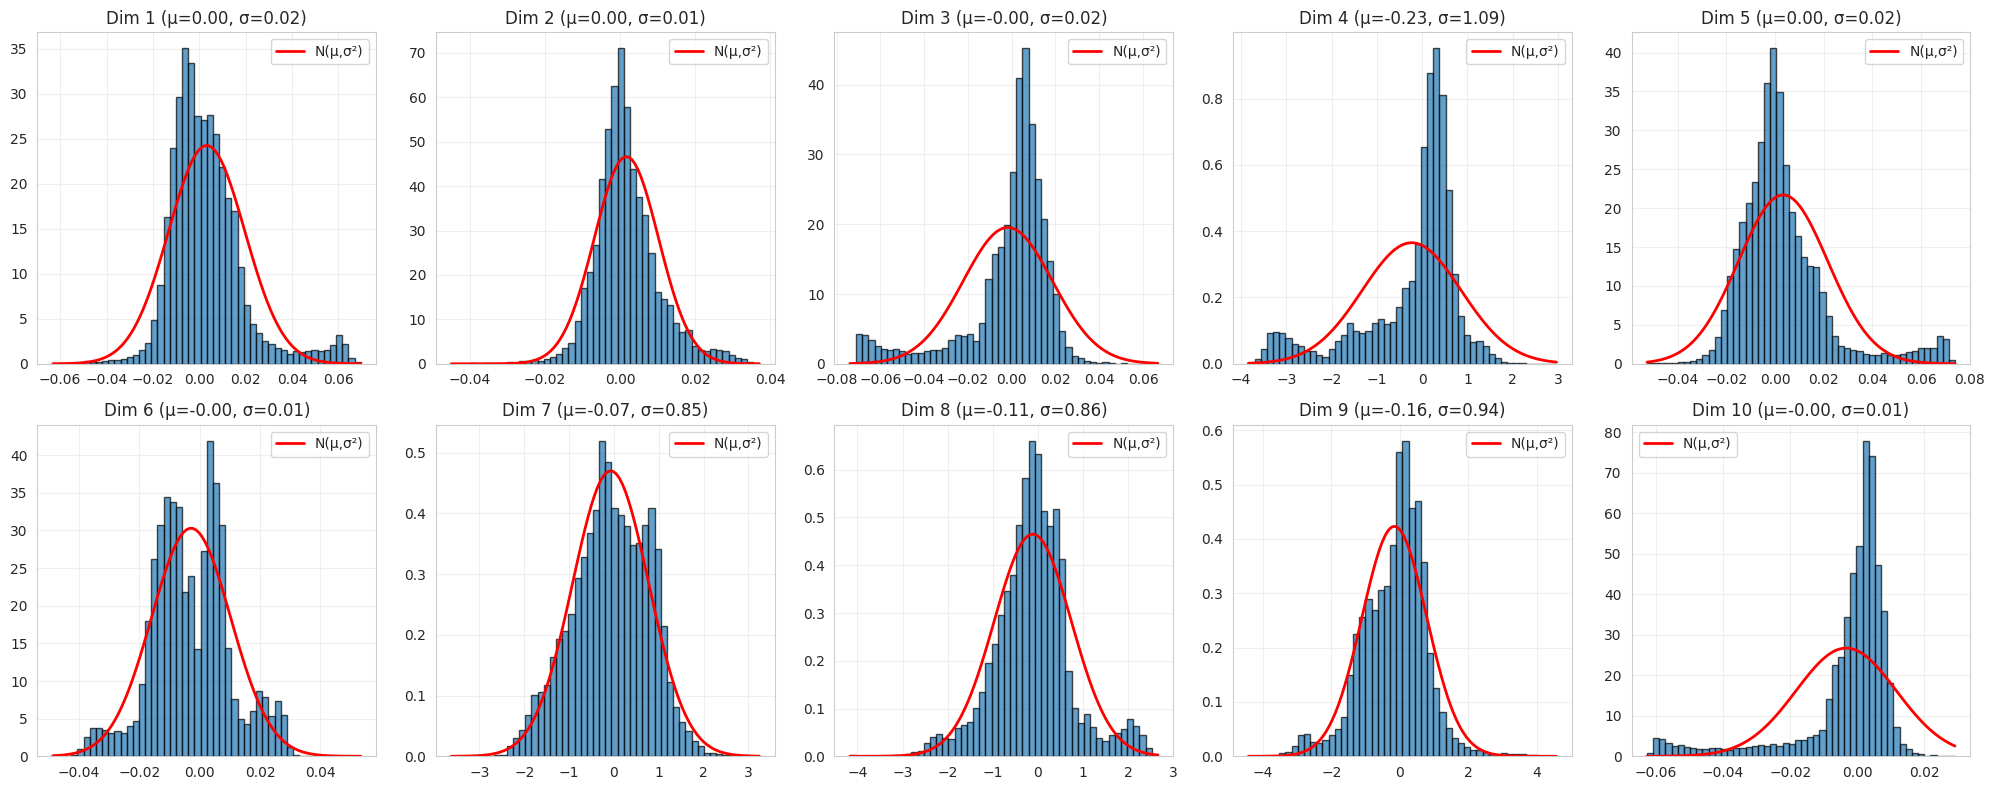

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    dim_data = latent[:, i]
    axes[i].hist(dim_data, bins=50, alpha=0.7, edgecolor='black', density=True)
    
    mu, sigma = dim_data.mean(), dim_data.std()
    x = np.linspace(dim_data.min(), dim_data.max(), 100)
    axes[i].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='N(μ,σ²)')
    
    axes[i].set_title(f'Dim {i+1} (μ={mu:.2f}, σ={sigma:.2f})')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Correlation Matrix

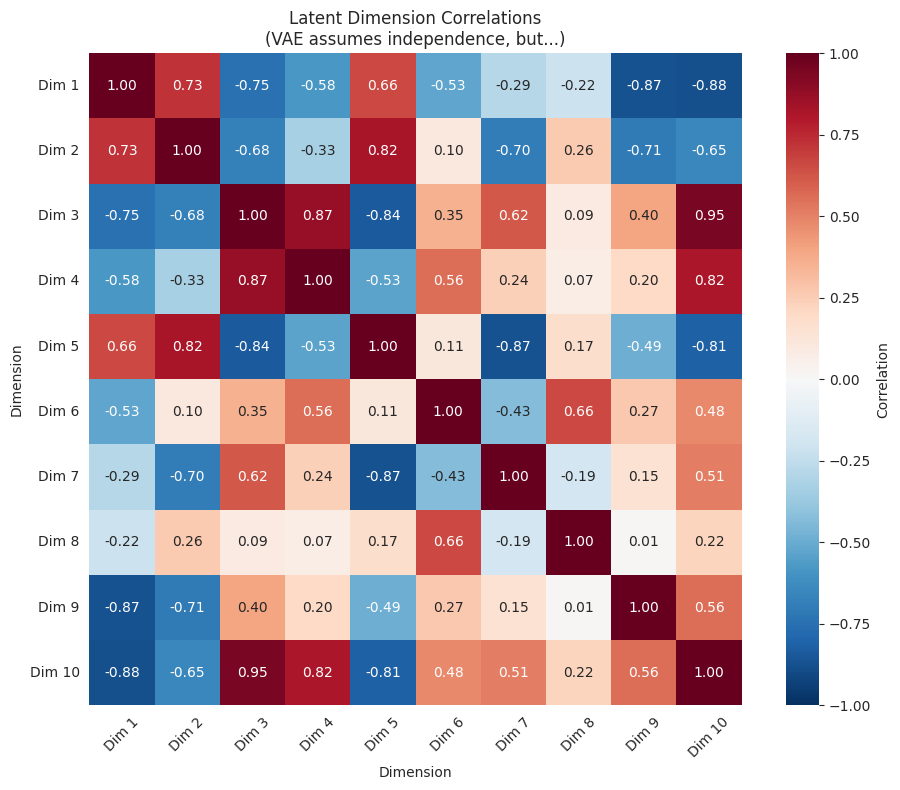

Max absolute correlation (off-diagonal): 0.950


In [8]:
corr_matrix = np.corrcoef(latent.T)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'})
plt.title('Latent Dimension Correlations\n(VAE assumes independence, but...)', fontsize=12)
plt.xlabel('Dimension')
plt.ylabel('Dimension')
plt.xticks(np.arange(10) + 0.5, [f'Dim {i+1}' for i in range(10)], rotation=45)
plt.yticks(np.arange(10) + 0.5, [f'Dim {i+1}' for i in range(10)], rotation=0)
plt.tight_layout()
plt.show()

max_corr = np.max(np.abs(corr_matrix - np.eye(10)))
print(f"Max absolute correlation (off-diagonal): {max_corr:.3f}")

## UMAP Projection

In [9]:
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
latent_2d = reducer.fit_transform(latent)

/home/utig5/johna/bhai/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/utig5/johna/bhai/.venv/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [14]:
[lithology_colors[lith]]

[array([0.12156863, 0.46666667, 0.70588235, 1.        ])]

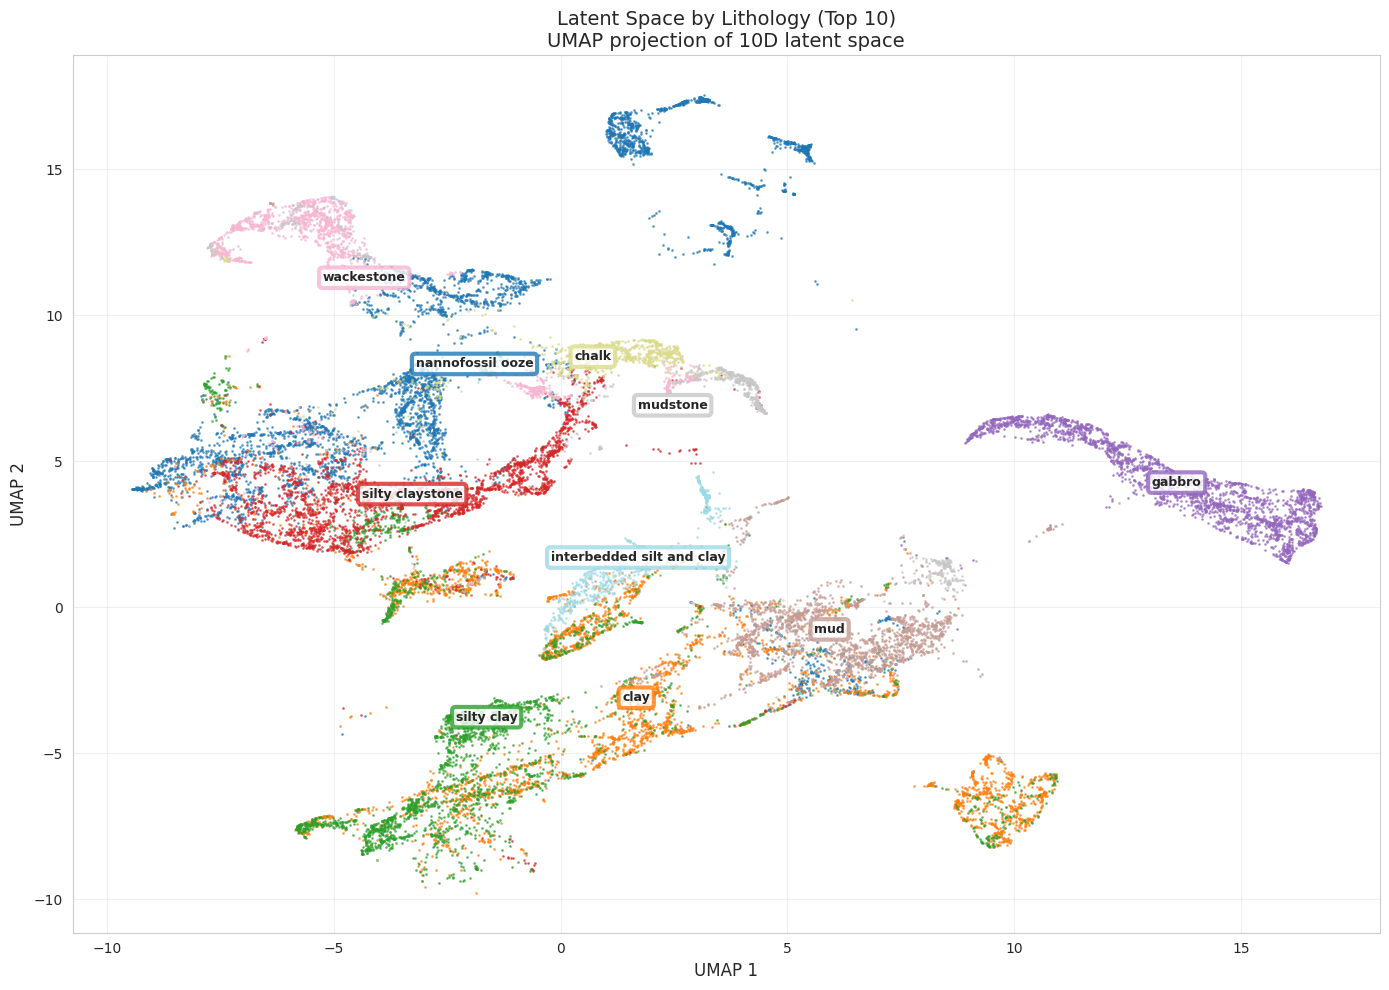

In [18]:
lithology_counts = pd.Series(y_test).value_counts()
top_10_lithologies = lithology_counts.head(10).index.tolist()

colors = plt.cm.tab20(np.linspace(0, 1, 10))
lithology_colors = {lith: colors[i] for i, lith in enumerate(top_10_lithologies)}

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

for lith in top_10_lithologies:
    mask = y_test == lith
    ax.scatter(latent_2d[mask, 0], latent_2d[mask, 1], 
               c=[lithology_colors[lith]], s=1, alpha=0.6, rasterized=True)

for lith in top_10_lithologies:
    mask = y_test == lith
    if mask.sum() > 0:
        centroid_x = latent_2d[mask, 0].mean()
        centroid_y = latent_2d[mask, 1].mean()
        ax.text(centroid_x, centroid_y, lith, 
                fontsize=9, weight='bold', 
                ha='center', va='center',
                # bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black'))
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=lithology_colors[lith], linewidth=3))

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('Latent Space by Lithology (Top 10)\nUMAP projection of 10D latent space', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Density Plot

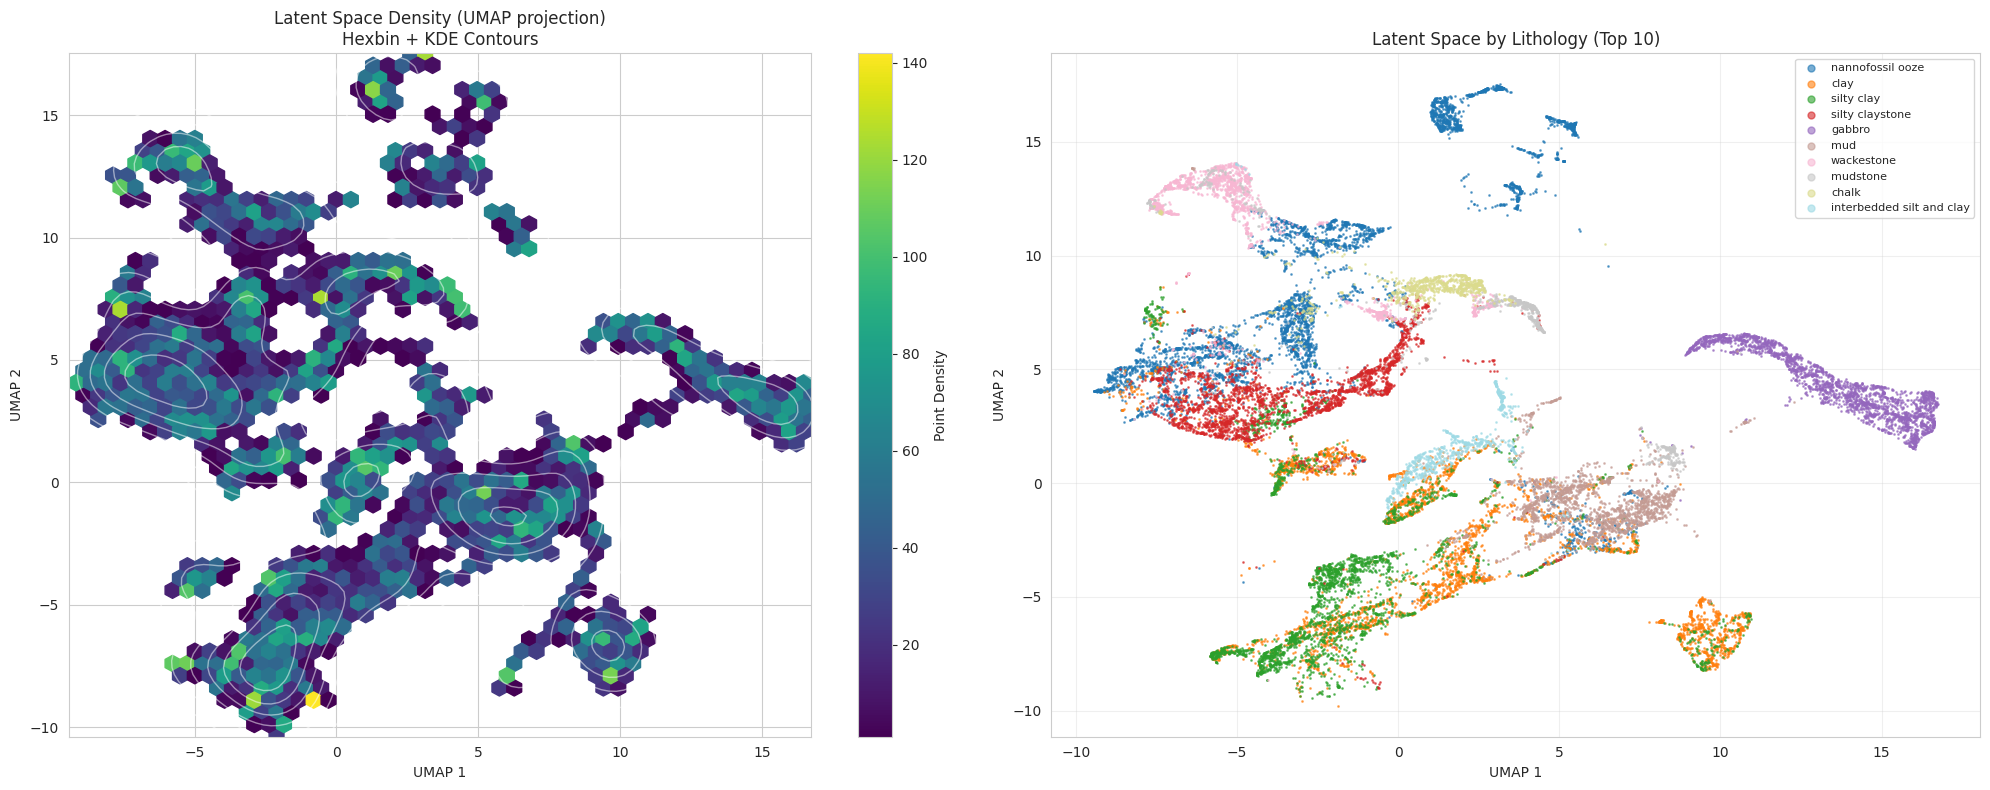

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

hb = ax1.hexbin(latent_2d[:, 0], latent_2d[:, 1], gridsize=50, cmap='viridis', mincnt=1)
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')
ax1.set_title('Latent Space Density (UMAP projection)\nHexbin + KDE Contours')
plt.colorbar(hb, ax=ax1, label='Point Density')

from scipy.stats import gaussian_kde
kde = gaussian_kde(latent_2d.T)
xx, yy = np.meshgrid(np.linspace(latent_2d[:, 0].min(), latent_2d[:, 0].max(), 100),
                     np.linspace(latent_2d[:, 1].min(), latent_2d[:, 1].max(), 100))
zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax1.contour(xx, yy, zz, colors='white', alpha=0.5, linewidths=1)

for lith in top_10_lithologies:
    mask = y_test == lith
    ax2.scatter(latent_2d[mask, 0], latent_2d[mask, 1], 
                c=[lithology_colors[lith]], s=1, alpha=0.6, label=lith, rasterized=True)

ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')
ax2.set_title('Latent Space by Lithology (Top 10)')
ax2.legend(loc='upper right', markerscale=5, fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()